# Visualization

In [1]:
# %load_ext autoreload
from jax import config
config.update("jax_debug_nans", True)
# config.update("jax_disable_jit", True)

import sys
import os
sys.path.append("/home/lauro/code/msc-thesis/svgd/kernel_learning/")
import json_tricks as json
import copy
from functools import partial

from tqdm import tqdm
from jax import grad, jit, vmap, random, lax, jacfwd, value_and_grad
from jax import lax
from jax.ops import index_update, index
import jax
import pandas as pd
import haiku as hk
from jax.experimental import optimizers

import config

import utils
import metrics
import time
import plot
import stein
import kernels
import distributions
import nets
import models

from jax.experimental import optimizers

key = random.PRNGKey(43)

import matplotlib.pyplot as plt
from scipy.stats import kde

import numpy as np
import jax.numpy as jnp

/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


See also
* animations: https://brushingupscience.com/2016/06/21/matplotlib-animations-the-easy-way/

# 3D Scatterplot

In [12]:
x = np.random.randn(3, 100)
y = np.random.randn(3, 100)

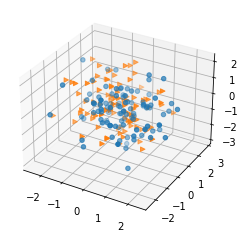

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*x)
ax.scatter(*y, marker=">")

# Backends

In [12]:
print("list available backends:")
%matplotlib --list

print("\nCurrent backend:")
%matplotlib

list available backends:
Available matplotlib backends: ['tk', 'gtk', 'gtk3', 'wx', 'qt4', 'qt5', 'qt', 'osx', 'nbagg', 'notebook', 'agg', 'svg', 'pdf', 'ps', 'inline', 'ipympl', 'widget']

Current backend:
Using matplotlib backend: agg


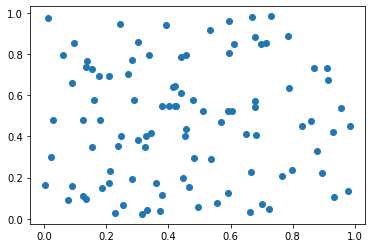

In [13]:
# this is how an agg plot looks
%matplotlib inline
plt.scatter(*np.random.rand(2, 100))

In [14]:
# this is how a widget plot looks
%matplotlib widget
plt.scatter(*np.random.rand(2, 100))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

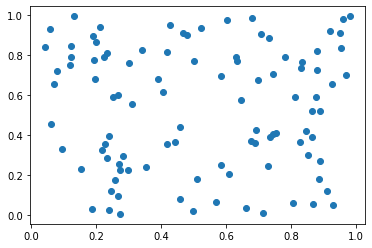

In [15]:
# go back to regular plots
%matplotlib inline
plt.scatter(*np.random.rand(2, 100))

# Animated scatterplot
needs `%matplotlib widget` to work

In [16]:
def animate_array(arr, fig=None, ax=None):
    """Animate array of shape (n_timesteps, n_points, 2)
    as moving scatterplot. Needs `%matplotlib widget` to work in Jupyter lab."""
    if ax is None:
        ax = plt.gca()
    if fig is None:
        fig = plt.gcf()

    # plot the first frame
    scat = ax.scatter(arr[0, :, 0], arr[0, :, 1])

    # animation fn
    def animate(i):
        scat.set_offsets(arr[i])
        ax.set_title(f"Timestep {i}")

    # call animation
    t = len(arr)
    anim = FuncAnimation(fig, animate, interval=100, frames=t)
    return anim

In [17]:
%matplotlib widget
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(figsize=(5, 3))
ax.set(xlim=(0, 1), ylim=(0, 1))

# data to plot
t = 30
arr = np.random.rand(t, 30, 2)

animate_array(arr, fig, ax)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Other Animations

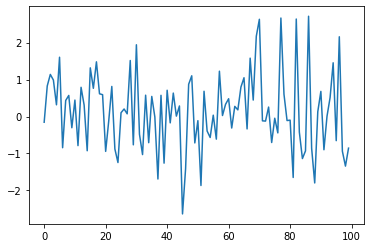

In [18]:
import time
import pylab as pl
from IPython import display
for i in range(10):
    pl.clf()
    pl.plot(pl.randn(100))
    display.display(pl.gcf())
    display.clear_output(wait=True)
    time.sleep(1.0)

Quoting from [stackexchange post](https://stackoverflow.com/questions/39658717/plot-dynamically-changing-graph-using-matplotlib-in-jupyter-notebook):
> I had been particularly looking for a good answer for the scenario where one thread is pumping data and we want Jupyter notebook to keep updating graph without blocking anything. After looking through about dozen or so related answers, here are some of the findings: This has a disadvantage that graph update occurs even if your data hasn't been updated yet. Below example shows another thread updating data while Jupyter notebook updating graph through

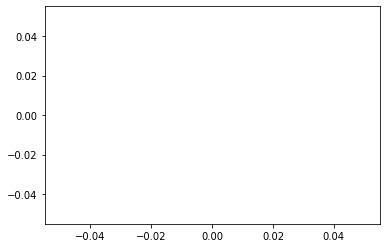

In [3]:
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from random import randrange
from threading import Thread
import time

class LiveGraph:
    def __init__(self):
        self.x_data, self.y_data = [], []
        self.figure = plt.figure()
        self.line, = plt.plot(self.x_data, self.y_data)
        self.animation = FuncAnimation(self.figure, self.update, interval=1000)
        self.th = Thread(target=self.thread_f, daemon=True)
        self.th.start()

    def update(self, frame):
        self.line.set_data(self.x_data, self.y_data)
        self.figure.gca().relim()
        self.figure.gca().autoscale_view()
        return self.line,

    def show(self):
        plt.show()

    def thread_f(self):
        x = 0
        while True:
            self.x_data.append(x)
            x += 1
            self.y_data.append(randrange(0, 100))   
            time.sleep(1)  

g = LiveGraph()
g.show()

# 2D colormesh

In [5]:
density = distributions.banana

<ipython-input-6-5c1700dc8bee>:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(*plot.make_meshgrid(density.pdf, lims=(-10,10)))


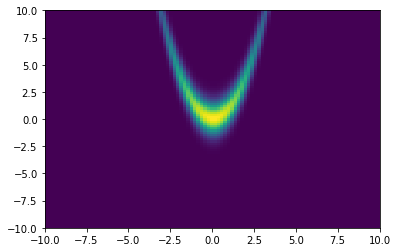

In [6]:
plt.pcolormesh(*plot.make_meshgrid(density.pdf, lims=(-10,10)))

<ipython-input-7-16cc652756da>:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(*plot.make_meshgrid(density.logpdf, lims=(-10,10)), vmin=-15, vmax=0)


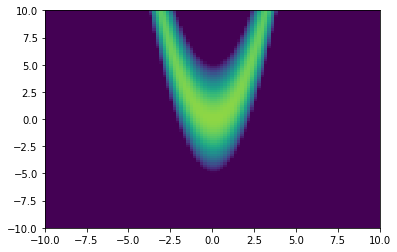

In [7]:
plt.pcolormesh(*plot.make_meshgrid(density.logpdf, lims=(-10,10)), vmin=-15, vmax=0)

In [8]:
grad_density1 = grad(density.pdf)
def grad_density(x, y):
    return grad_density1(np.append(x, y))

In [9]:
def quiverplot(f, num_gridpoints=50, lims=[-10, 10], xlims=None, ylims=None, angles="xy", scale=2, **kwargs):
    """
    Plot a vector field. f is a function f: R^2 ---> R^2
    If arrows are too large, change scale (larger scale = shorter arrows)
    """
    if xlims is None:
        xlims = lims
    if ylims is None:
        ylims = lims

    def split_f(x, y):
        return f(np.append(x, y))

    x = np.linspace(*xlims, num_gridpoints)
    y = np.linspace(*ylims, num_gridpoints)
    xx, yy = np.meshgrid(x, y, dtype=np.float32)
    zz = vmap(vmap(split_f))(xx, yy)
    uu, vv = np.rollaxis(zz, 2)

    plt.quiver(xx, yy, uu, vv, angles=angles, scale=scale, **kwargs)

<ipython-input-11-d4c4e92a484d>:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(*plot.make_meshgrid(density.pdf, lims=(-10,10)), cmap="Oranges")


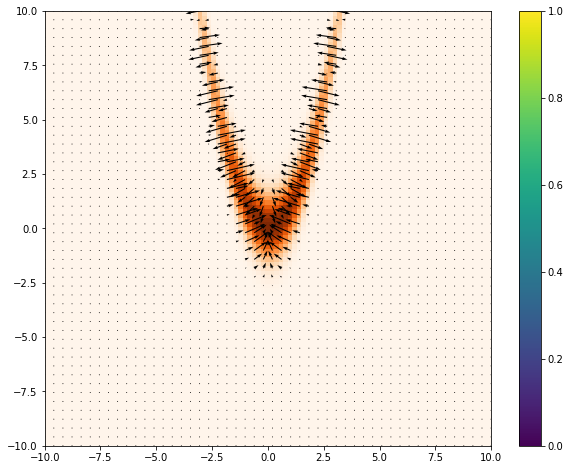

In [11]:
plt.subplots(figsize=[10,8])
plt.pcolormesh(*plot.make_meshgrid(density.pdf, lims=(-10,10)), cmap="Oranges")
quiverplot(grad_density1)
plt.colorbar()